### Importing Necessary Libraries

In [62]:
import os
import pickle
from PIL import Image
from directory_tree import display_tree

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from xgboost import XGBClassifier

## Data

The training data consists of $16000$ images along with their labels.

In [3]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]
labels

id                        images  label
0          0      ./Data/train/train/0.tif      1
1          1      ./Data/train/train/1.tif     13
2          2      ./Data/train/train/2.tif     13
3          3      ./Data/train/train/3.tif     14
4          4      ./Data/train/train/4.tif      6
...      ...                           ...    ...
15995  15995  ./Data/train/train/15995.tif      2
15996  15996  ./Data/train/train/15996.tif     15
15997  15997  ./Data/train/train/15997.tif      3
15998  15998  ./Data/train/train/15998.tif      9
15999  15999  ./Data/train/train/15999.tif      9

[16000 rows x 3 columns]

The labels are ranging from $0-15$ for the following mentioned document types.

In [4]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})
label_names

labels                   names
0        0                  letter
1        1                    form
2        2                   email
3        3             handwritten
4        4           advertisement
5        5       scientific report
6        6  scientific publication
7        7           specification
8        8             file folder
9        9            news article
10      10                  budget
11      11                 invoice
12      12            presentation
13      13           questionnaire
14      14                  resume
15      15                    memo

There is no class imbalance in the training dataset and each class is well represented with $\sim 1000$ images per class label.

In [5]:
pd.value_counts(labels['label'])

8     1059
6     1044
0     1032
12    1020
5     1012
11    1011
13    1007
9     1000
3      993
14     992
15     988
10     974
1      969
2      968
4      966
7      965
Name: label, dtype: int64

Let's take a look at the document images for each class to get an idea of what sort of documents and their images we are dealing with.

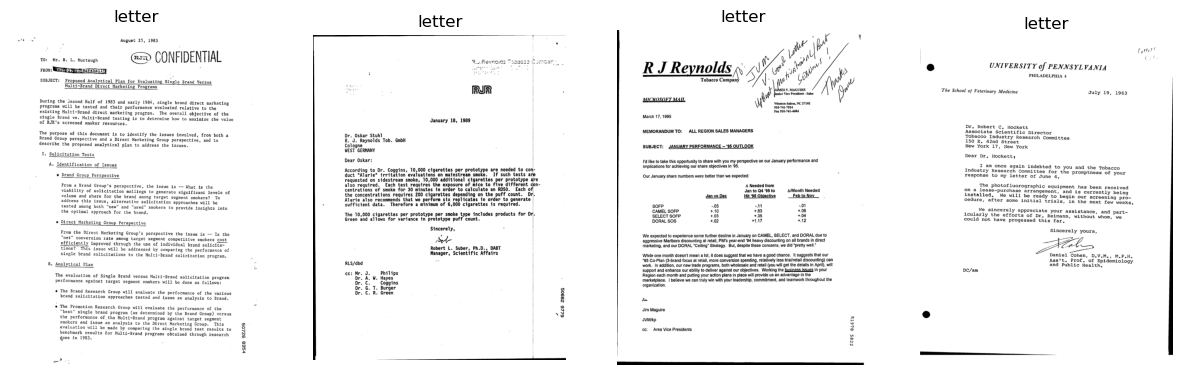

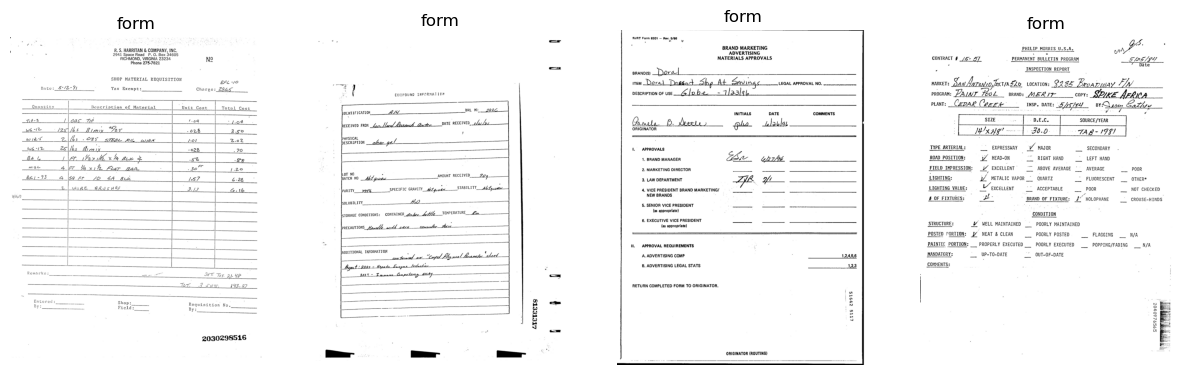

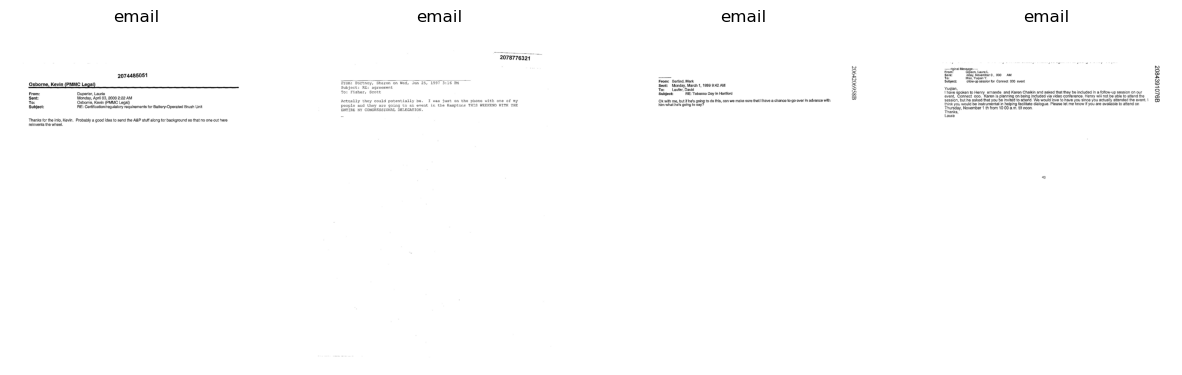

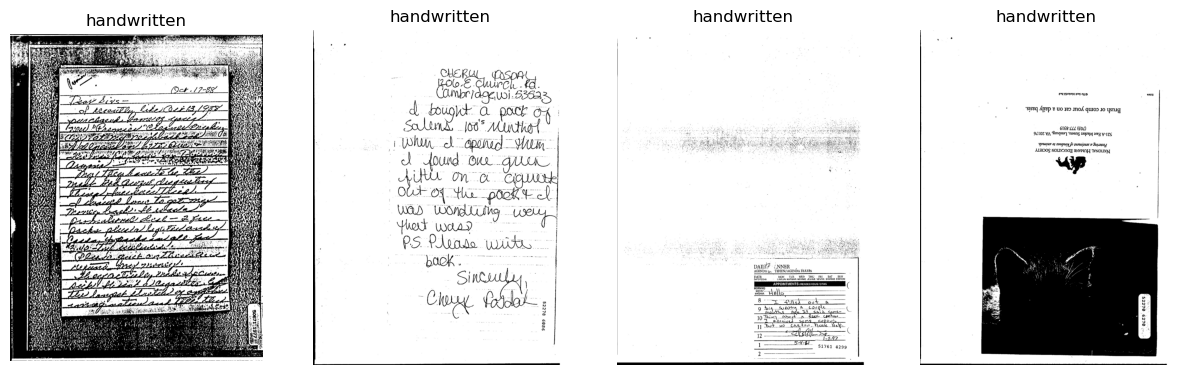

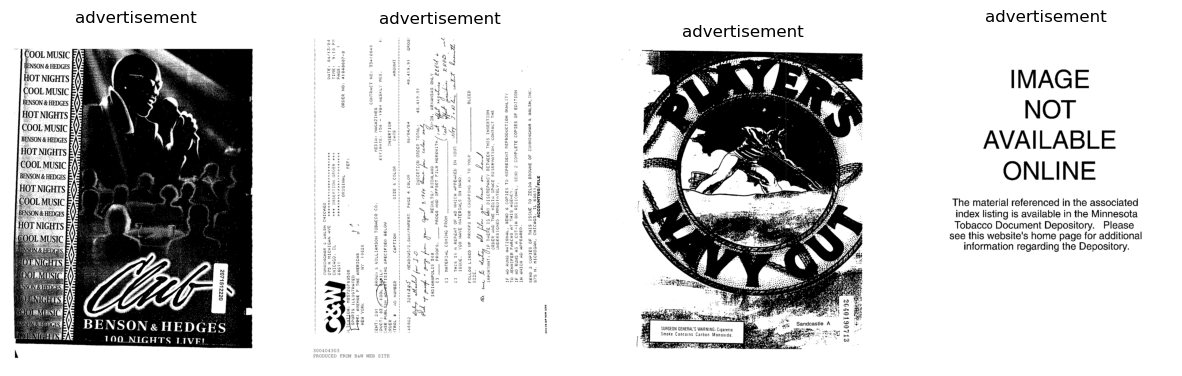

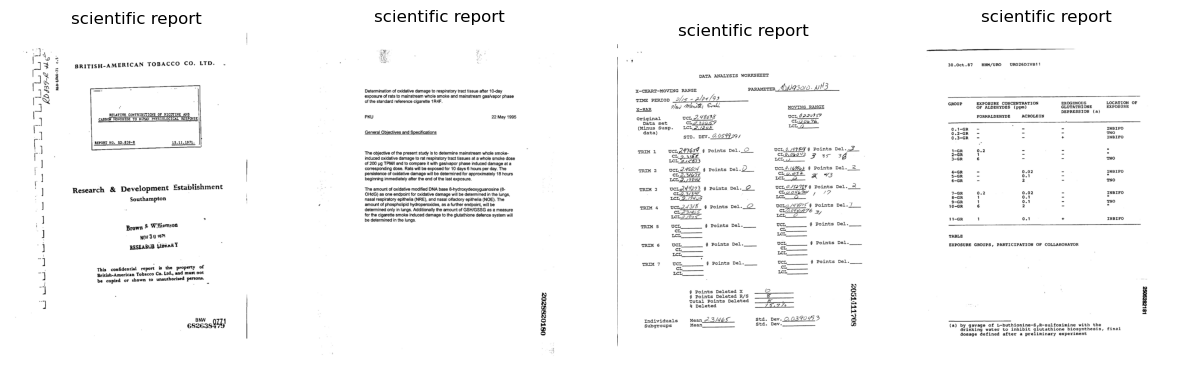

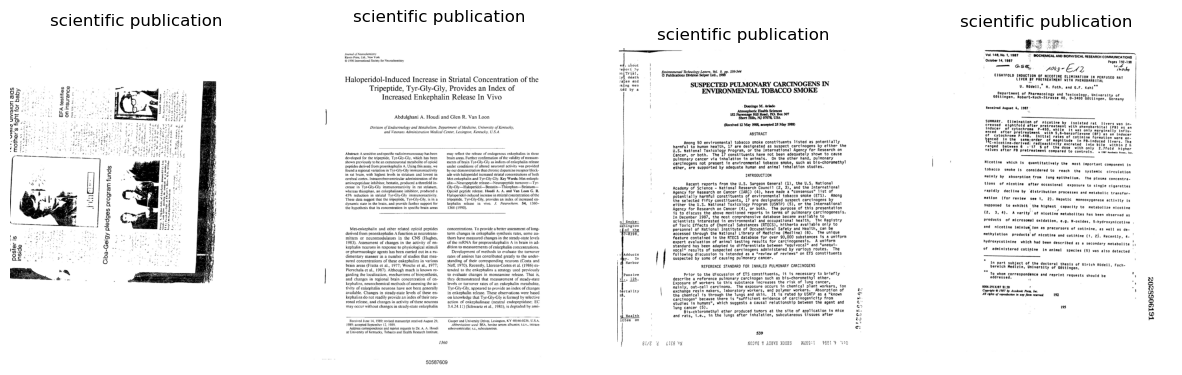

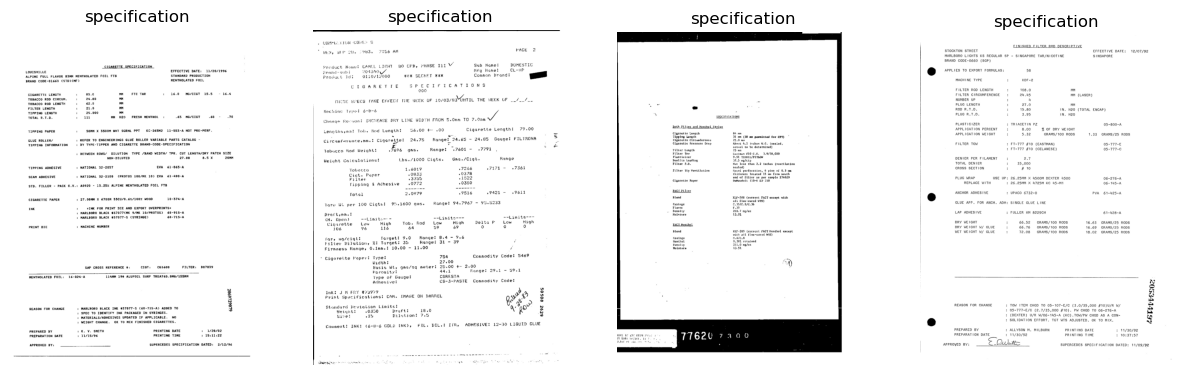

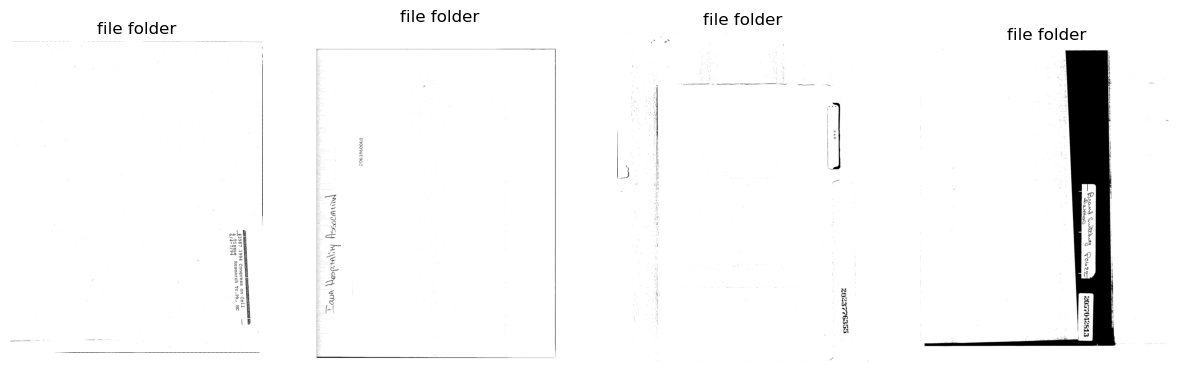

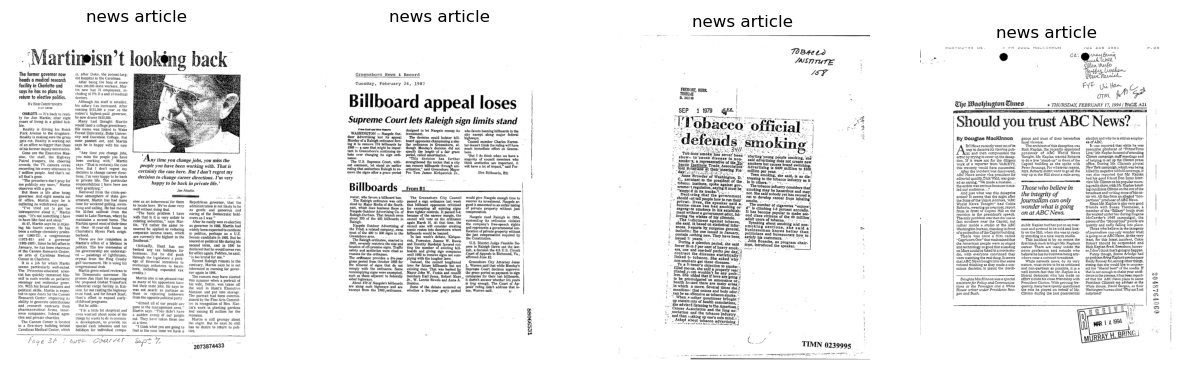

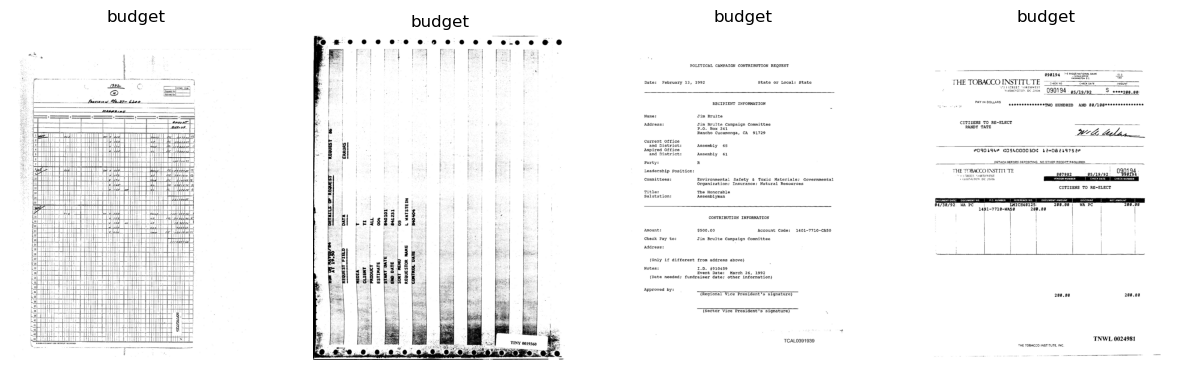

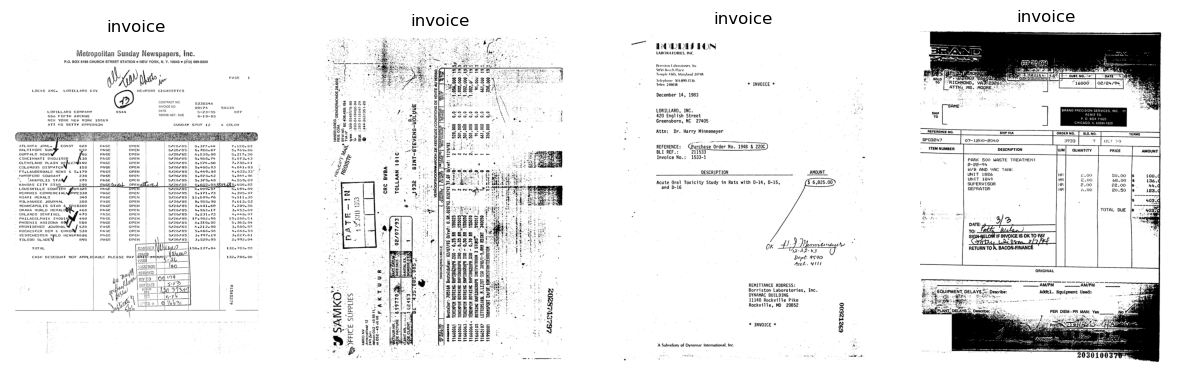

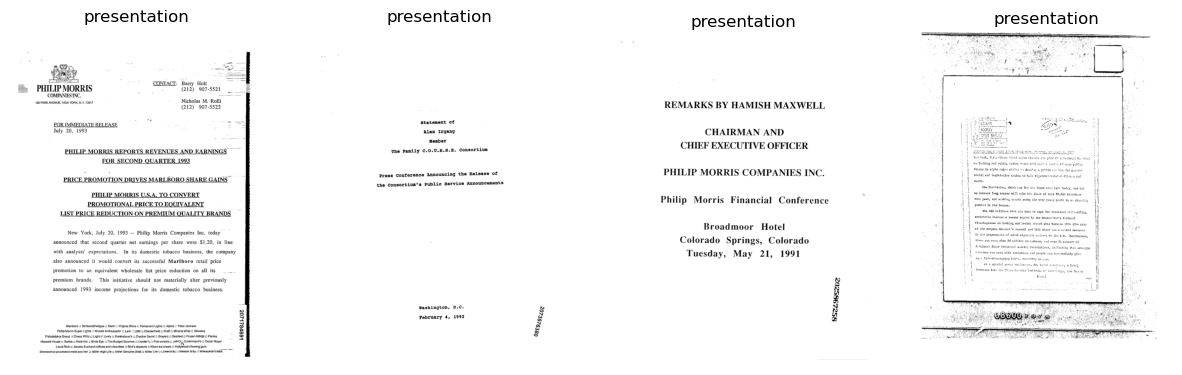

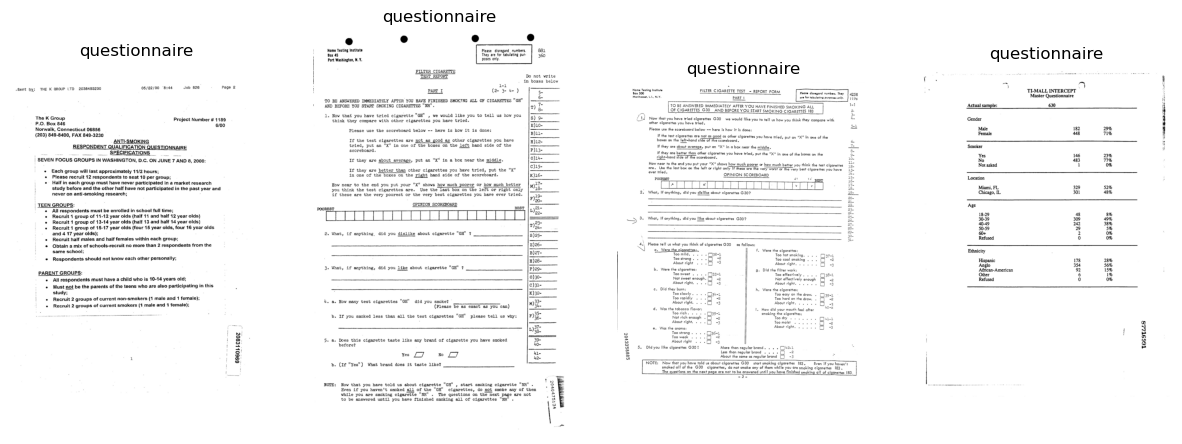

In [8]:
for i in range(len(class_labels)):
    fig, ax = plt.subplots(1, 4, figsize=(15, 30))
    imgs = [tf.cast(img_to_array(load_img(name)), dtype=tf.uint8) for name in list(labels[labels.label == i][:4]['images'])]
    m = 0
    for k in range(4):
        ax[k].imshow(imgs[m])
        ax[k].axis('off')
        ax[k].set_title(class_names[i])
        m += 1

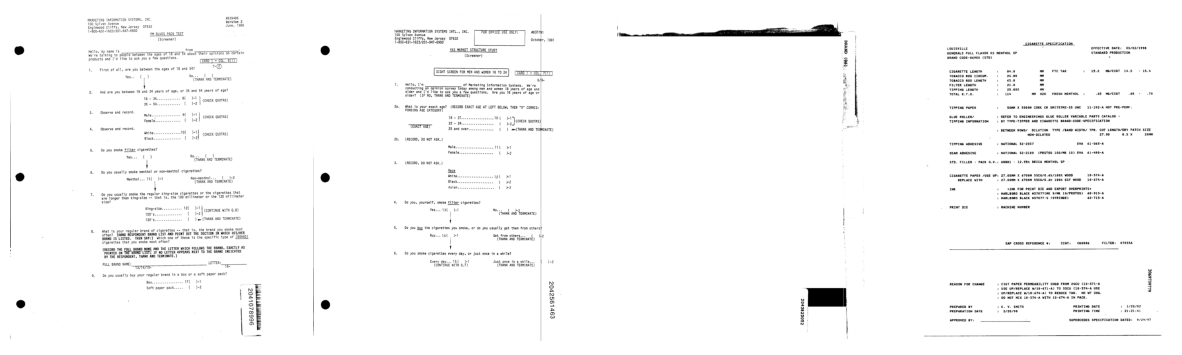

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(15, 30))
imgs = [tf.cast(img_to_array(load_img('./Data/validation/validation/'+name)), dtype=tf.uint8) for name in os.listdir('./Data/validation/validation')[:4]]
m = 0
for k in range(4):
    ax[k].imshow(imgs[m])
    ax[k].axis('off')
    m += 1

## Data Preparation

Since, there is a lot of image data instead of using the whole data at once in a tensor form, we would be using a data generator to prevent memory issues.

In [10]:
heights = [img.shape[0] for img in imgs]
widths = [img.shape[1] for img in imgs]
print("")
print("Mean Image Height:", np.mean(heights))
print("Mean Image Width:", np.mean(widths))
print("Min Image Height:", np.min(heights))
print("Min Image Width:", np.min(widths))


Mean Image Height: 1000.0
Mean Image Width: 770.5
Min Image Height: 1000
Min Image Width: 754


Observing the average image heights and widths, it is observed that setting image height to $1000$ and image width to $750$ is reseonable for training the model.

In [11]:
BATCH_SIZE = 40
INPUT_SHAPE = (800, 600)

Since, the Keras' own data generator does not support TIFF images, we resort to writing our own custom data generator. It can also be leveraged to put custom image pre-processing or multi-input or output in the data processing pipeline.

In [12]:
class ImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, X_col, y_col, batch_size, input_size=(800, 600), shuffle=True):
        self.df = df.copy() # DataFrame consisting image paths of inputs and the labels for the outputs
        self.X_col = X_col # Input column, specifying image path, in the DataFrame
        self.y_col = y_col # Output column, specifying corresponding label, in the DataFrame
        self.batch_size = batch_size # Batch Size
        self.input_size = input_size # Input Image size
        self.shuffle = shuffle # Shuffle Data after each epoch
        self.n = len(self.df) # length of the entire data
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, path):
        img_arr = img_to_array(load_img(path))
        # some other pre-processing / data-augmentation goes here
        img_arr = tf.image.resize(img_arr, self.input_size)
        return img_arr/255.0
    
    def __get_data(self, batches):
        batch_paths = batches[self.X_col]
        batch_labels = batches[self.y_col]
        X_batch = tf.cast([self.__get_input(path) for path in batch_paths], dtype=tf.float32)
        y_batch = tf.cast(batch_labels, dtype=tf.float32)
        return X_batch, y_batch
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [13]:
train_generator = ImageDataGenerator(
    df=labels,
    X_col='images',
    y_col='label',
    batch_size=BATCH_SIZE,
    input_size=INPUT_SHAPE,
    shuffle=False
)

Below shows one batch from the ImageDataGenerator.

In [14]:
batch = next(iter(train_generator))
print('*** Batch Overview ***')
print('Input Image Tensor Shape:', batch[0].shape)
print('Output Label Tensor Shape:', batch[1].shape)

*** Batch Overview ***
Input Image Tensor Shape: (40, 800, 600, 3)
Output Label Tensor Shape: (40,)


In [15]:
fig, ax = plt.subplots(BATCH_SIZE//16, 16, figsize=(20, 10))
imgs = batch[0]
labs = list(batch[1].numpy())
m = 0
for j in range(BATCH_SIZE//16):
    for k in range(16):
        ax[j, k].imshow((imgs[m]*255).numpy().astype(np.uint8))
        ax[j, k].axis('off')
        ax[j, k].set_title(labs[m])
        m += 1

## Model Building

Now, a basic CNN-based model will be put to place. It will utilize the visual features only to classify the documents. Later we will be building much more better models considering other structures and multi-modality of the images and distinctive features.

- EfficientNetV2L

The EfficientNetV2L is a large model and since, we are not pre-training the entire model, we will just fine-tune it with two extra layers. So, to fasten training we precompute the output of the EfficientNetV2L model and use this for training the added Dense Layers for Fine-Tuning.

In [16]:
inputs = Input(shape=(*INPUT_SHAPE, 3))
model = EfficientNetV2L(include_top=False, input_tensor=inputs, weights='imagenet')
model.trainable = False
outputs = GlobalAvgPool2D(name='avg_pool')(model.output)
model = tf.keras.Model(inputs, outputs, name='EfficientNet')

In [ ]:
model.summary()

The EfficientNetV2L gives a 3D output per image with $1280$ channels which are collapsed using GlobalAveragePooling2D and we get a 1280 representation vector per image which will be used to train the later extra layers of our model.

In [18]:
fine_tune_data = np.load('./Data/EffNet-train-precompute/whole_train_data_precomp.npy')
fine_tune_data.shape

(16000, 1280)

In [19]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

The fine-tuning part of our model.

In [36]:
inputs = Input(shape=1280)
x = BatchNormalization()(inputs)

top_dropout_rate = 0.2
x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
x = Dropout(top_dropout_rate, name='top_dropout_final')(x)
outputs = Dense(16, activation='softmax', name='pred')(x)

model1 = tf.keras.Model(inputs, outputs, name='EfficientNet-FineTune')

In [37]:
model1.summary()

Model: "EfficientNet-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1280)]            0         
                                                                 
 batch_normalization_1 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 top_dropout_1 (Dropout)     (None, 1280)              0         
                                                                 
 top_dense_1 (Dense)         (None, 1024)              1311744   
                                                                 
 top_dropout_2 (Dropout)     (None, 1024)              0         
                                                                 
 top_dense_2 (Dense)         (None, 512)               524800    
                                             

The fine-tuned model which was trained before is loaded here, and we will proceed towards fitting XGBoost.

In [38]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))
model1.load_weights('./Models/EfficientNet/basic-model-weights')

We extract the $512$D representation vector from the fine-ture layers to train out XGBoost Model.

In [41]:
out = model1.layers[-3].output
model2 = tf.keras.Model(model1.input, out, name='EfficientNet-FT-XG-Feature')

In [42]:
model2.summary()

Model: "EfficientNet-FT-XG-Feature"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1280)]            0         
                                                                 
 batch_normalization_1 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 top_dropout_1 (Dropout)     (None, 1280)              0         
                                                                 
 top_dense_1 (Dense)         (None, 1024)              1311744   
                                                                 
 top_dropout_2 (Dropout)     (None, 1024)              0         
                                                                 
 top_dense_2 (Dense)         (None, 512)               524800    
                                        

In [45]:
xgb_train_data = model2.predict(fine_tune_data)

  1/500 [..............................] - ETA: 1:19

2022-09-10 03:39:23.458350: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-10 03:39:23.495976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 2s 3ms/step


In [46]:
xgb_train_data.shape

(16000, 512)

### Model Training

We fit the XGBoost Decision Tree Model using the $512D$ feature vector representation from the Fine-Tuned EfficientNetV2L Model.

In [47]:
xgbmodel = XGBClassifier(objective='multi:softprob', num_class= 16)
xgbmodel.fit(xgb_train_data, fine_tune_labels)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_class=16, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0, ...)

In [63]:
file_name = "./Models/EfficientNet-XGBoost/xgb_mod.pkl"
pickle.dump(xgbmodel, open(file_name, "wb"))

### Model Evaluation

#### On Train Data

Now, after the model is being trained, we will look at the performance of the model on the training set.

In [48]:
xgbmodel.score(xgb_train_data, fine_tune_labels)

0.9998125

In [50]:
train_pred_labels = xgbmodel.predict(xgb_train_data)

In [51]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [59]:
mistakes = np.sum(train_pred_labels == labels['label'])
mistakes

15997

Looking at the misclassified images to get a better idea about what features the model is unable to capture.

In [60]:
mis_train_data = labels[train_pred_labels != labels['label']]
mis_train_data

id                        images  label
9682    9682   ./Data/train/train/9682.tif     12
12896  12896  ./Data/train/train/12896.tif      9
15333  15333  ./Data/train/train/15333.tif      7

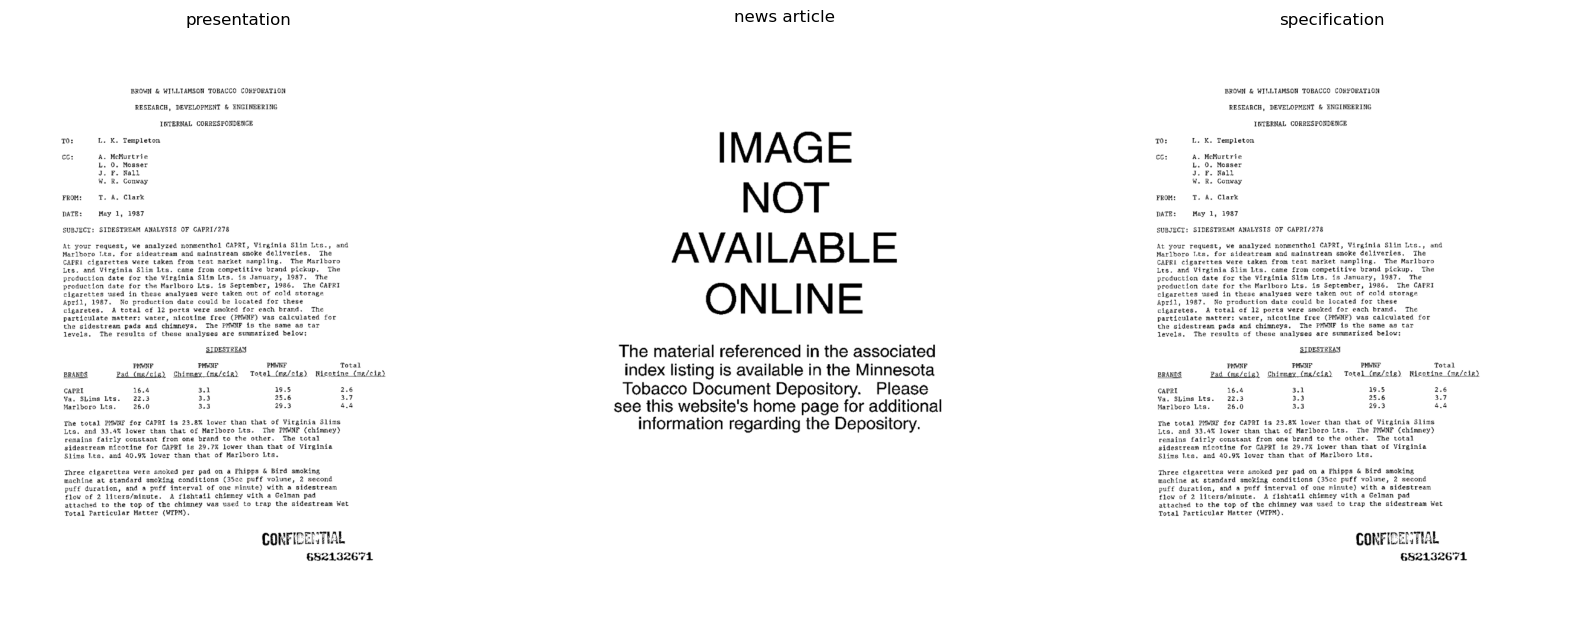

In [79]:
imgs = [img_to_array(load_img(name)) for name in list(mis_train_data['images'].to_numpy())]
fig, ax = plt.subplots(1, len(mis_train_data), figsize=(20, 10))
labs = list(mis_train_data['label'].to_numpy())
m = 0
for k in range(len(mis_train_data)):
    ax[k].imshow(imgs[m].astype(np.uint8))
    ax[k].axis('off')
    ax[k].set_title(class_names[labs[m]])
    m += 1

#### On Validation Data

Generating Predictions for the Validation Set

In [64]:
class ImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, X_col, batch_size, input_size=(800, 600), shuffle=True):
        self.df = df.copy() # DataFrame consisting image paths of inputs and the labels for the outputs
        self.X_col = X_col # Input column, specifying image path, in the DataFrame
        self.batch_size = batch_size # Batch Size
        self.input_size = input_size # Input Image size
        self.shuffle = shuffle # Shuffle Data after each epoch
        self.n = len(self.df) # length of the entire data
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, path):
        img_arr = img_to_array(load_img(path))
        # some other pre-processing / data-augmentation goes here
        img_arr = tf.image.resize(img_arr, self.input_size)
        return img_arr/255.0
    
    def __get_data(self, batches):
        batch_paths = batches[self.X_col]
        X_batch = tf.cast([self.__get_input(path) for path in batch_paths], dtype=tf.float32)
        return X_batch
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X = self.__get_data(batches)
        return X
    
    def __len__(self):
        return self.n // self.batch_size

In [65]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data

images
0    ./Data/validation/validation/18282.tif
1    ./Data/validation/validation/18296.tif
2    ./Data/validation/validation/17833.tif
3    ./Data/validation/validation/17827.tif
4    ./Data/validation/validation/18241.tif
..                                      ...
895  ./Data/validation/validation/18502.tif
896  ./Data/validation/validation/18264.tif
897  ./Data/validation/validation/18258.tif
898  ./Data/validation/validation/17802.tif
899  ./Data/validation/validation/17816.tif

[900 rows x 1 columns]

In [66]:
valid_generator = ImageDataGenerator(
    df=validation_data,
    X_col='images',
    batch_size=30,
    shuffle=False
)

In [67]:
valid_preds = model.predict(valid_generator)
valid_preds = model2.predict(valid_preds)
valid_preds = xgbmodel.predict(valid_preds)

2022-09-10 03:53:22.870624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step


2022-09-10 03:54:41.508030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [97]:
validation_data['labels'] = valid_preds
validate_data = validation_data.sample(n=40)
imgs = [img_to_array(load_img(name)) for name in list(validate_data['images'].to_numpy())]
fig, ax = plt.subplots(10, 4, figsize=(10, 30))
labs = list(validate_data['labels'].to_numpy())
m = 0
for j in range(10):
    for k in range(4):
        ax[j, k].imshow(imgs[m].astype(np.uint8))
        ax[j, k].axis('off')
        ax[j, k].set_title(class_names[labs[m]])
        m += 1

### Submission

For Kaggle Submission

In [81]:
submission_data = pd.DataFrame({'id':[name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]})
submission_data['label'] = valid_preds
submission_data.sort_values(by=['id'], inplace=True)
submission_data

id  label
850  17801      4
898  17802      6
852  17803      4
798  17804      8
750  17805      3
..     ...    ...
246  18696      7
211  18697     12
760  18698      8
787  18699      3
891  18700      4

[900 rows x 2 columns]

In [82]:
submission_data.to_csv('./Submissions/submission-3.csv', index=False)